# <center>Modeling and Simulation of Astrobee<center>

<p align="center">
  <center><img src="Astrobee.png" width="500" height="276"><center>
  <center>Source: <a href="https://ntrs.nasa.gov/search.jsp?R=20180003515">Fl&uumlckiger et al. (2018)</a><center>
</p>

## Configuration

Available configurations: 

 - "original" $\rightarrow$ models Astrobee in the stowed configuration with the physical parameters listed by NASA
 - "stowed"   $\rightarrow$ models Astrobee with its robotic arm stowed
 - "deployed" $\rightarrow$ models Astrobee with its robotic arm deployed and holding a tool

In [1]:
configuration = "original"

## Dependencies

In [2]:
import sympy as sm
import sympy.physics.mechanics as me
from pydy.system import System
import numpy as np
import matplotlib.pyplot as plt
from pydy.codegen.ode_function_generators import generate_ode_function
from scipy.integrate import odeint
import scipy.io as sio
me.init_vprinting()

## Reference Frames

In [3]:
ISS = me.ReferenceFrame('N') # ISS RF
B = me.ReferenceFrame('B') # body RF

q1, q2, q3 = me.dynamicsymbols('q1:4') # attitude coordinates (Euler angles)

B.orient(ISS, 'Body', (q1, q2, q3), 'xyz') # body RF

In [4]:
t = me.dynamicsymbols._t

## Significant Points

In [5]:
O = me.Point('O') # fixed point in the ISS
O.set_vel(ISS, 0)

In [6]:
x, y, z = me.dynamicsymbols('x, y, z') # translation coordinates (position of the mass-center of Astrobee relative to 'O')
l = sm.symbols('l') # length of Astrobee (side of cube)

In [7]:
C = O.locatenew('C', x * ISS.x + y * ISS.y + z * ISS.z) # Astrobee CM

## Kinematical Differential Equations

In [8]:
ux = me.dynamicsymbols('u_x')
uy = me.dynamicsymbols('u_y')
uz = me.dynamicsymbols('u_z')
u1 = me.dynamicsymbols('u_1')
u2 = me.dynamicsymbols('u_2')
u3 = me.dynamicsymbols('u_3')

In [9]:
z1 = sm.Eq(ux, x.diff())
z2 = sm.Eq(uy, y.diff())
z3 = sm.Eq(uz, z.diff())
z4 = sm.Eq(u1, q1.diff())
z5 = sm.Eq(u2, q2.diff())
z6 = sm.Eq(u3, q3.diff())
u = sm.solve([z1, z2, z3, z4, z5, z6], x.diff(), y.diff(), z.diff(), q1.diff(), q2.diff(), q3.diff())
u

In [10]:
# ux_dot = me.dynamicsymbols('u_x_d')
# uy_dot = me.dynamicsymbols('u_y_d')
# uz_dot = me.dynamicsymbols('u_z_d')
# u1_dot = me.dynamicsymbols('u_1_d')
# u2_dot = me.dynamicsymbols('u_2_d')
# u3_dot = me.dynamicsymbols('u_3_d')

In [11]:
# z1d = sm.Eq(ux_dot, ux.diff())
# z2d = sm.Eq(uy_dot, uy.diff())
# z3d = sm.Eq(uz_dot, uz.diff())
# z4d = sm.Eq(u1_dot, u1.diff())
# z5d = sm.Eq(u2_dot, u2.diff())
# z6d = sm.Eq(u3_dot, u3.diff())
# ud = sm.solve([z1d, z2d, z3d, z4d, z5d, z6d], ux.diff(), uy.diff(), uz.diff(), u1.diff(), u2.diff(), u3.diff())
# ud

## Translational Motion

### Velocity

In [12]:
C.set_vel(ISS, C.pos_from(O).dt(ISS).subs(u))
V_B_ISS_ISS = C.vel(ISS)
V_B_ISS_ISS # "velocity of Astrobee CM w.r.t ISS RF expressed in ISS RF" 

### Acceleration

In [13]:
A_B_ISS_ISS = C.acc(ISS).subs(u) #.subs(ud)
A_B_ISS_ISS # "acceleration of Astrobee CM w.r.t ISS RF expressed in ISS RF" 

## Angular Motion

### Angular Velocity

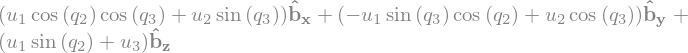

In [14]:
B.set_ang_vel(ISS, B.ang_vel_in(ISS).subs(u))
Omega_B_ISS_B = B.ang_vel_in(ISS)
Omega_B_ISS_B # "angular velocity of body RF w.r.t ISS RF expressed in body RF" 

### Angular Acceleration

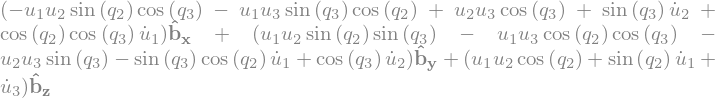

In [15]:
Alpha_B_ISS_B = B.ang_acc_in(ISS).subs(u) #.subs(ud)
Alpha_B_ISS_B # "angular acceleration of body RF w.r.t ISS RF expressed in body RF" 

## Mass and Inertia

In [16]:
m = sm.symbols('m') # Astrobee mass

Ix, Iy, Iz = sm.symbols('I_x, I_y, I_z') # principal moments of inertia

I = me.inertia(B, Ix, Iy, Iz) # inertia dyadic
I

## Loads

### Forces

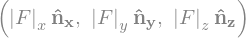

In [17]:
Fx_mag, Fy_mag, Fz_mag = me.dynamicsymbols('Fmag_x, Fmag_y, Fmag_z')

Fx = Fx_mag * ISS.x
Fy = Fy_mag * ISS.y
Fz = Fz_mag * ISS.z

Fx, Fy, Fz

### 

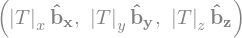

In [18]:
Tx_mag, Ty_mag, Tz_mag = me.dynamicsymbols('Tmag_x, Tmag_y, Tmag_z')

Tx = Tx_mag * B.x
Ty = Ty_mag * B.y
Tz = Tz_mag * B.z

Tx, Ty, Tz

## Kane's Method

In [19]:
kdes = [z1.rhs - z1.lhs, z2.rhs - z2.lhs, z3.rhs - z3.lhs, z4.rhs - z4.lhs, z5.rhs - z5.lhs, z6.rhs - z6.lhs]

In [20]:
body = me.RigidBody('body', C, B, m, (I, C))
bodies = [body]

In [21]:
loads = [(C, Fx),
         (C, Fy),
         (C, Fz),
         (B, Tx),
         (B, Ty),
         (B, Tz)
        ]

In [22]:
kane = me.KanesMethod(ISS, (x, y, z, q1, q2, q3), (ux, uy, uz, u1, u2, u3), kd_eqs=kdes)

In [23]:
fr, frstar = kane.kanes_equations(bodies, loads=loads)

In [24]:
# fr

In [25]:
# frstar

## Simulation

In [26]:
sys = System(kane)

In [27]:
sys.constants_symbols

In [28]:
if configuration == "original":
    sys.constants = {Ix: 0.1083,
                     Iy: 0.1083,
                     Iz: 0.1083,
                     m: 7
                     }
    
elif configuration == "stowed":
    sys.constants = {Ix: 0.185,
                     Iy: 0.202,
                     Iz: 0.188,
                     m: 15.878
                     }

elif configuration == "deployed":
    sys.constants = {Ix: 0.186,
                     Iy: 0.253,
                     Iz: 0.237,
                     m: 16.029
                     }

In [29]:
sys.constants

In [30]:
sys.times = np.linspace(0.0, 50.0, num=1000)

In [31]:
sys.coordinates

In [32]:
sys.speeds

In [33]:
sys.states

In [34]:
sys.initial_conditions = {x: 0.0,
                          y: 0.0,
                          z: 0.0,
                          q1: 0.0,
                          q2: 0.0,
                          q3: 0.0,
                          ux: 0.2,
                          uy: 0.0,
                          uz: 0.0,
                          u1: 0.0,
                          u2: 0.0,
                          u3: 0.5
                         }

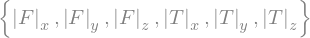

In [35]:
sys.specifieds_symbols

In [36]:
sys.specifieds = {Fx_mag: 0.0,
                  Fy_mag: 0.0,
                  Fz_mag: 0.0,
                  Tx_mag: 0.0,
                  Ty_mag: 0.0,
                  Tz_mag: 0.0
                 }

In [37]:
states = sys.integrate()

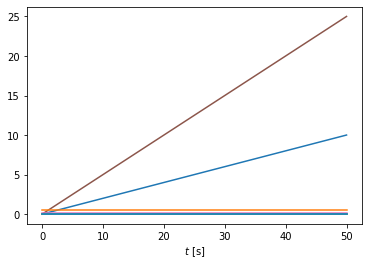

In [38]:
fig, ax = plt.subplots()
ax.plot(sys.times, states)
ax.set_xlabel('{} [s]'.format(sm.latex(t, mode='inline')));
plt.show()

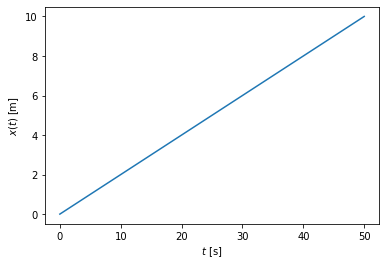

In [39]:
fig, ax = plt.subplots()
ax.plot(sys.times, states[:, 0])
ax.set_xlabel('{} [s]'.format(sm.latex(t, mode='inline'))); ax.set_ylabel('{} [m]'.format(sm.latex(x, mode='inline')));
plt.show()

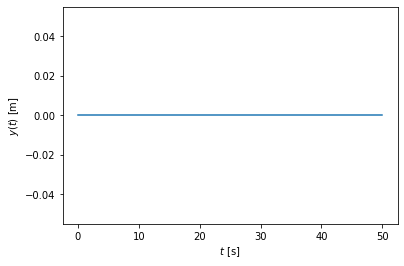

In [40]:
fig, ax = plt.subplots()
ax.plot(sys.times, states[:, 1])
ax.set_xlabel('{} [s]'.format(sm.latex(t, mode='inline'))); ax.set_ylabel('{} [m]'.format(sm.latex(y, mode='inline')));
plt.show()

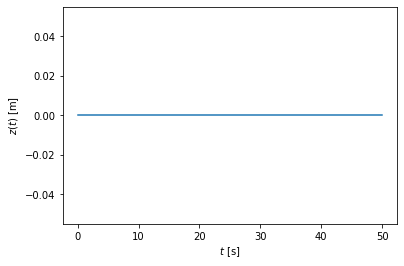

In [41]:
fig, ax = plt.subplots()
ax.plot(sys.times, states[:, 2])
ax.set_xlabel('{} [s]'.format(sm.latex(t, mode='inline'))); ax.set_ylabel('{} [m]'.format(sm.latex(z, mode='inline')));
plt.show()

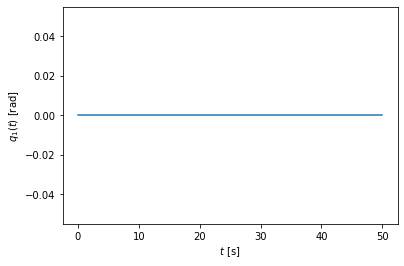

In [42]:
fig, ax = plt.subplots()
ax.plot(sys.times, states[:, 3])
ax.set_xlabel('{} [s]'.format(sm.latex(t, mode='inline'))); ax.set_ylabel('{} [rad]'.format(sm.latex(q1, mode='inline')));
plt.show()

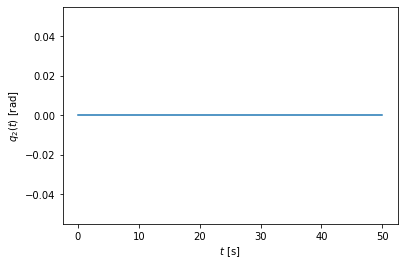

In [43]:
fig, ax = plt.subplots()
ax.plot(sys.times, states[:, 4])
ax.set_xlabel('{} [s]'.format(sm.latex(t, mode='inline'))); ax.set_ylabel('{} [rad]'.format(sm.latex(q2, mode='inline')));
plt.show()

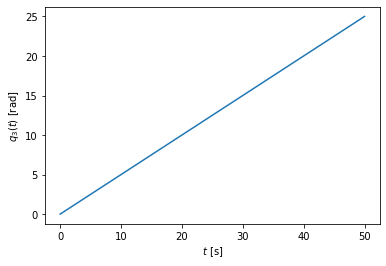

In [44]:
fig, ax = plt.subplots()
ax.plot(sys.times, states[:, 5])
ax.set_xlabel('{} [s]'.format(sm.latex(t, mode='inline'))); ax.set_ylabel('{} [rad]'.format(sm.latex(q3, mode='inline')));
plt.show()

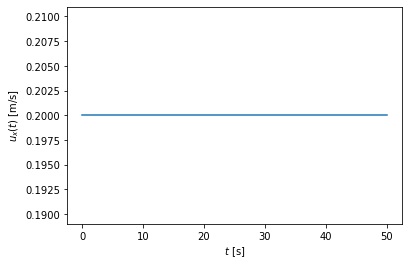

In [45]:
fig, ax = plt.subplots()
ax.plot(sys.times, states[:, 6])
ax.set_xlabel('{} [s]'.format(sm.latex(t, mode='inline'))); ax.set_ylabel('{} [m/s]'.format(sm.latex(ux, mode='inline')));
plt.show()

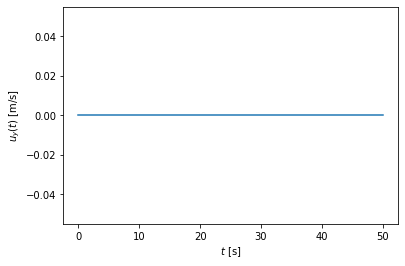

In [46]:
fig, ax = plt.subplots()
ax.plot(sys.times, states[:, 7])
ax.set_xlabel('{} [s]'.format(sm.latex(t, mode='inline'))); ax.set_ylabel('{} [m/s]'.format(sm.latex(uy, mode='inline')));
plt.show()

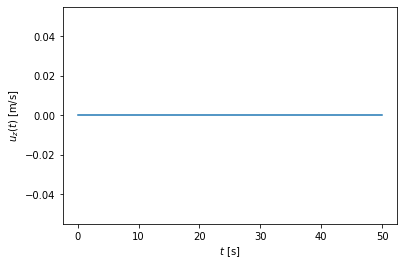

In [47]:
fig, ax = plt.subplots()
ax.plot(sys.times, states[:, 8])
ax.set_xlabel('{} [s]'.format(sm.latex(t, mode='inline'))); ax.set_ylabel('{} [m/s]'.format(sm.latex(uz, mode='inline')));
plt.show()

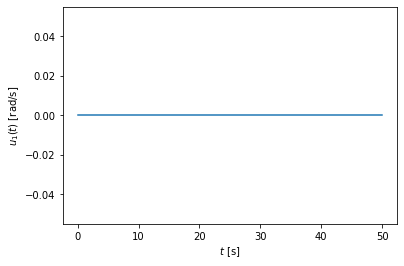

In [48]:
fig, ax = plt.subplots()
ax.plot(sys.times, states[:, 9])
ax.set_xlabel('{} [s]'.format(sm.latex(t, mode='inline'))); ax.set_ylabel('{} [rad/s]'.format(sm.latex(u1, mode='inline')));
plt.show()

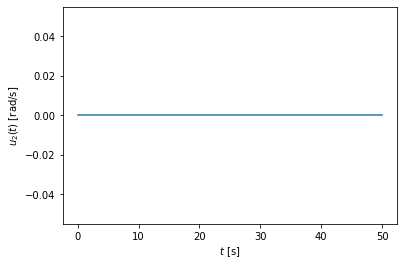

In [49]:
fig, ax = plt.subplots()
ax.plot(sys.times, states[:, 10])
ax.set_xlabel('{} [s]'.format(sm.latex(t, mode='inline'))); ax.set_ylabel('{} [rad/s]'.format(sm.latex(u2, mode='inline')));
plt.show()

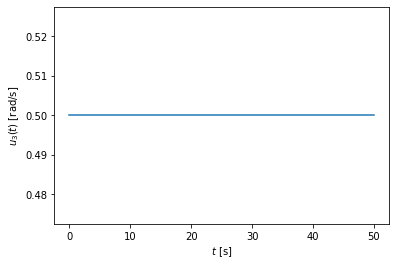

In [50]:
fig, ax = plt.subplots()
ax.plot(sys.times, states[:, 11])
ax.set_xlabel('{} [s]'.format(sm.latex(t, mode='inline'))); ax.set_ylabel('{} [rad/s]'.format(sm.latex(u3, mode='inline')));
plt.show()

## 3D Visualization

In [51]:
from pydy.viz.shapes import Cube, Cylinder, Sphere, Plane
from pydy.viz.visualization_frame import VisualizationFrame
from pydy.viz import Scene
from ipywidgets import Image, Video
import pythreejs as pjs
from stl import mesh

In [52]:
if configuration == "original":

    l = 0.32

    body_m_shape = Cube(l, color='black')
    body_l_shape = Cube(l, color='green')
    body_r_shape = Cube(l, color='green')

    v1 = VisualizationFrame('Body_m',
                            B,
                            C.locatenew('C_m', (1/6) * l * B.z),
                            body_m_shape)

    v2 = VisualizationFrame('Body_l',
                            B,
                            C.locatenew('C_l', (3/8) * l * -B.y),
                            body_l_shape)

    v3 = VisualizationFrame('Body_r',
                            B,
                            C.locatenew('C_l', (3/8) * l * B.y),
                            body_l_shape)

    scene = Scene(ISS, O, v1, v2, v3, system=sys)
    scene.create_static_html(overwrite=True, silent=True)

    body_m_mesh = pjs.Mesh(
        pjs.BoxBufferGeometry(l, (1/2) * l, (2/3) * l),
        pjs.MeshStandardMaterial(color='black'),
        name="Body_m"
    )

    body_l_mesh = pjs.Mesh(
        pjs.BoxBufferGeometry(l, (1/4) * l, l),
        pjs.MeshStandardMaterial(color='green'),
        name="Body_l"
    )

    body_r_mesh = pjs.Mesh(
        pjs.BoxBufferGeometry(l, (1/4) * l, l),
        pjs.MeshStandardMaterial(color='green'),
        name="Body_r"
    )

    body_m_matrices = v1.evaluate_transformation_matrix(states, list(sys.constants.values()))
    body_l_matrices = v2.evaluate_transformation_matrix(states, list(sys.constants.values()))
    body_r_matrices = v3.evaluate_transformation_matrix(states, list(sys.constants.values()))

    body_m_track = pjs.VectorKeyframeTrack(
        name='scene/Body_m.matrix',
        times=list(sys.times),
        values=body_m_matrices)

    body_l_track = pjs.VectorKeyframeTrack(
        name='scene/Body_l.matrix',
        times=list(sys.times),
        values=body_l_matrices)

    body_r_track = pjs.VectorKeyframeTrack(
        name='scene/Body_r.matrix',
        times=list(sys.times),
        values=body_r_matrices)

    body_m_mesh.matrixAutoUpdate = False
    body_l_mesh.matrixAutoUpdate = False
    body_r_mesh.matrixAutoUpdate = False

    body_m_mesh.matrix = body_m_matrices[0]
    body_l_mesh.matrix = body_l_matrices[0]
    body_r_mesh.matrix = body_r_matrices[0]

    x_arrow = pjs.ArrowHelper(dir=[1, 0, 0], length=0.75, color='blue')
    y_arrow = pjs.ArrowHelper(dir=[0, 1, 0], length=0.75, color='red')
    z_arrow = pjs.ArrowHelper(dir=[0, 0, 1], length=0.75,color='green')

    view_width = 960
    view_height = 720

    camera = pjs.PerspectiveCamera(position=[1, 1, 1],
                                   aspect=view_width/view_height)
    key_light = pjs.DirectionalLight(position=[1, 1, 0])
    ambient_light = pjs.AmbientLight()

    scene_pjs = pjs.Scene(children=[body_m_mesh, body_l_mesh, body_r_mesh,
                                    x_arrow, y_arrow, z_arrow, 
                                    camera, key_light, ambient_light])

    controller = pjs.OrbitControls(controlling=camera)
    renderer = pjs.Renderer(camera=camera, scene=scene_pjs, controls=[controller], width=view_width, height=view_height)
    
elif configuration == "stowed" or "deployed":
    
    body_shape = Cube(0.2, color='gray')

    v1 = VisualizationFrame('Body_m',
                            B,
                            C,
                            body_shape)

    scene = Scene(ISS, O, v1, system=sys)
    scene.create_static_html(overwrite=True, silent=True)

    if configuration == "stowed":
        body_mesh = mesh.Mesh.from_file('CAD/astrobee_stowed_1.stl')
    elif configuration == "deployed":
        body_mesh = mesh.Mesh.from_file('CAD/astrobee_deployed_1.stl')
        
    body_vertices = pjs.BufferAttribute(array=body_mesh.vectors, normalized=False)
    body_geometry = pjs.BufferGeometry(attributes={'position': body_vertices}, )
    my_mesh = pjs.Mesh(body_geometry, pjs.MeshStandardMaterial(color='blue'),
        name='body')

    volume, cog, inertia = body_mesh.get_mass_properties()
    print("Volume                                  = {0}".format(volume))
    print("Position of the center of gravity (COG) = {0}".format(cog))
    print("Inertia matrix at expressed at the COG  = {0}".format(inertia[0,:]))
    print("                                          {0}".format(inertia[1,:]))
    print("                                          {0}".format(inertia[2,:]))

    body_matrices = v1.evaluate_transformation_matrix(states, list(sys.constants.values()))

    body_track = pjs.VectorKeyframeTrack(
        name='scene/body.matrix',
        times=list(sys.times),
        values=body_matrices)

    my_mesh.matrixAutoUpdate = False

    my_mesh.matrix = body_matrices[0]
    
    scale = 2 * np.ndarray.max(body_mesh.points.flatten(order='C'))

    x_arrow = pjs.ArrowHelper(dir=[1, 0, 0], length=scale, color='blue')
    y_arrow = pjs.ArrowHelper(dir=[0, 1, 0], length=scale, color='red')
    z_arrow = pjs.ArrowHelper(dir=[0, 0, 1], length=scale, color='green')

    view_width = 960
    view_height = 720

    camera = pjs.PerspectiveCamera(position=[1, 1, 1],
                                   aspect=view_width/view_height)
    key_light = pjs.DirectionalLight(position=[0, 1, 1])
    ambient_light = pjs.AmbientLight()

    scene_pjs = pjs.Scene(children=[my_mesh,
                                    x_arrow, y_arrow, z_arrow, 
                                    camera, key_light, ambient_light])

    controller = pjs.OrbitControls(controlling=camera)
    renderer = pjs.Renderer(camera=camera, scene=scene_pjs, controls=[controller], width=view_width, height=view_height)

In [53]:
# scale = body_mesh.points.flatten(order='C')
# scale

## Linearization

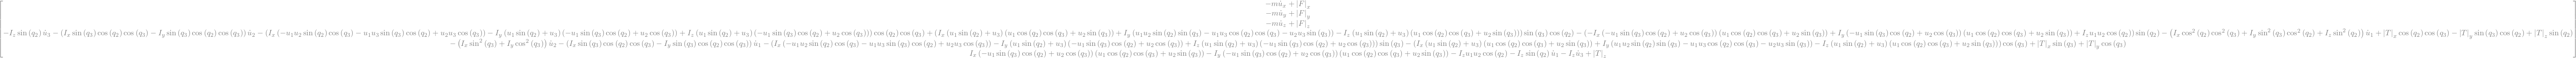

In [54]:
f = fr + frstar
f

In [55]:
V = { 
      x: 0.0,
      y: 0.0,
      z: 0.0,
      q1: 0.0,
      q2: 0.0,
      q3: 0.0,
      ux: 0.0,
      uy: 0.0,
      uz: 0.0,
      u1: 0.0,
      u2: 0.0,
      u3: 0.0,
      Fx_mag: 0.0,
      Fy_mag: 0.0,
      Fz_mag: 0.0,
      Tx_mag: 0.0,
      Ty_mag: 0.0,
      Tz_mag: 0.0
}

V_keys = sm.Matrix([ v for v in V.keys() ])
V_values = sm.Matrix([ v for v in V.values() ])

In [56]:
f_lin = f.subs(V) + f.jacobian(V_keys).subs(V)*(V_keys - V_values)

In [57]:
# sm.simplify(f)

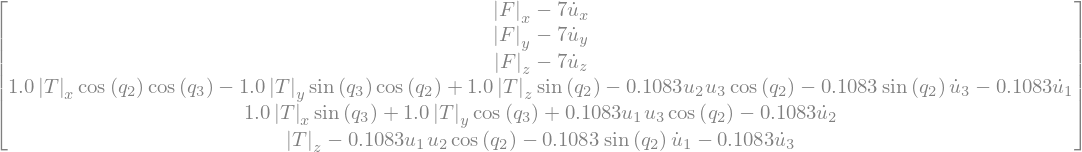

In [58]:
sm.simplify(f.subs(sys.constants))

In [59]:
us = sm.Matrix([ux, uy, uz, u1, u2, u3])
us_diff = sm.Matrix([ux.diff(), uy.diff(), uz.diff(), u1.diff(), u2.diff(), u3.diff()])
qs = sm.Matrix([x, y, z, q1, q2, q3])
rs = sm.Matrix([Fx_mag, Fy_mag, Fz_mag, Tx_mag, Ty_mag, Tz_mag])

If $f_{lin}$ is used, $M_l \rightarrow$ singular 

$\because$ inversion of $M_l$ is required, use $f$ and then substitute for $V$

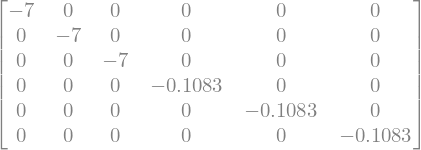

In [60]:
Ml = f.jacobian(us_diff).subs(sys.constants).subs(V)
Ml

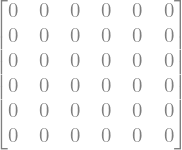

In [61]:
Cl = f.jacobian(us).subs(V)
Cl.subs(sys.constants)

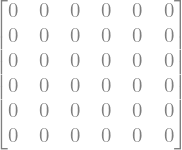

In [62]:
Kl = f.jacobian(qs).subs(V)
sm.simplify(Kl.subs(sys.constants))

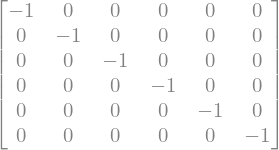

In [63]:
Hl = -f.jacobian(rs).subs(V)
sm.simplify(Hl.subs(sys.constants))

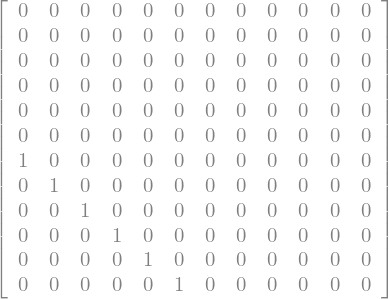

In [64]:
A = sm.Matrix([[(-Ml.inv()*Cl), (-Ml.inv()*Kl)], [(sm.eye(6)), sm.zeros(6, 6)]])
sm.simplify(A.subs(sys.constants))

In [65]:
A_matrix = np.array(sm.simplify(A.subs(sys.constants))).astype(np.float64)
sio.savemat('Control/Matrices/A_matrix.mat', {'A_matrix': A_matrix})

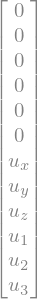

In [66]:
sm.simplify(A).subs(sys.constants)*(us.col_join(qs))

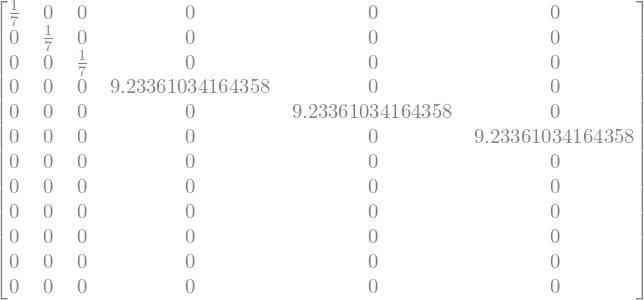

In [67]:
B = sm.Matrix([[Ml.inv() * Hl], [sm.zeros(6, 6)]])
sm.nsimplify(B.subs(sys.constants))

In [68]:
# B = sm.Matrix([[0.063, 0, 0, 0, 0, 0], [0, 0.063, 0, 0, 0, 0], [0, 0, 0.063, 0, 0, 0], [0, 0, 0, 5.4, 0, 0], [0, 0, 0, 0, 4.95, 0], [0, 0, 0, 0, 0, 5.32], sm.zeros(6,6)])
# B

In [69]:
B_matrix = np.array(sm.simplify(B.subs(sys.constants))).astype(np.float64)

if configuration == "original":
    sio.savemat('Control/Matrices/B_original.mat', {'B_original': B_matrix})
    
elif configuration == "stowed":
    sio.savemat('Control/Matrices/B_stowed.mat', {'B_stowed': B_matrix})

elif configuration == "deployed":
    sio.savemat('Control/Matrices/B_deployed.mat', {'B_deployed': B_matrix})

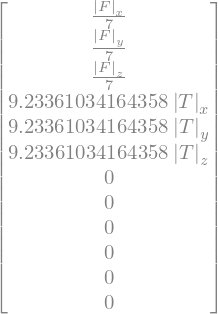

In [70]:
sm.simplify(B).subs(sys.constants)*(rs)

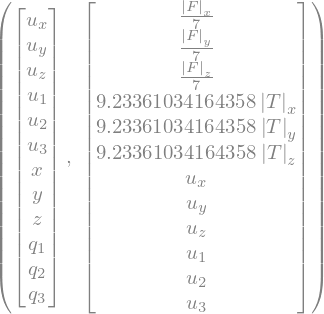

In [71]:
us.col_join(qs), (sm.simplify(A).subs(sys.constants)*(us.col_join(qs)) + sm.simplify(B).subs(sys.constants)*(rs)) # (x, Ax + Bu) => x_dot = Ax + Bu?

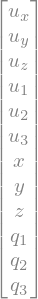

In [72]:
(us.col_join(qs))

In [73]:
renderer

Renderer(camera=PerspectiveCamera(aspect=1.3333333333333333, position=(1.0, 1.0, 1.0), quaternion=(0.0, 0.0, 0…

In [74]:
if configuration == "original":
    clip = pjs.AnimationClip(tracks=[body_m_track, body_l_track, body_r_track], duration=sys.times[-1])
    
elif configuration == "stowed" or "deployed":
    clip = pjs.AnimationClip(tracks=[body_track], duration=sys.times[-1])

action = pjs.AnimationAction(pjs.AnimationMixer(scene_pjs), clip, scene_pjs)
action

AnimationAction(clip=AnimationClip(duration=50.0, tracks=(VectorKeyframeTrack(name='scene/Body_m.matrix', time…